In [1]:
# import the netCDF4 module
import netCDF4
import numpy as np
import datetime

In [2]:
# load the categorize file in the data folder
f = netCDF4.Dataset('data/20180624_leipzig_categorize.nc')
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    location: Leipzig
    title: Cloud categorization products from Leipzig, 2018-06-24
    day: 24
    month: 6
    year: 2018
    history: 27 Jun 2018 07:55:46 - Generated from level 1 data by Ewan O'Connor <e.j.oconnor@reading.ac.uk>
Radar history: Original data has been averaged to 30 seconds.
Lidar history: File converted with convert_pollyxt.m
Model history: 27-Jun-2018 07:52:19: Created from GDAS1 profiles produced with the profile binary in the HYSPLIT offline package using convert_gdas12pro.sh.
Gauge history: created from parsivel2-data by Patric Seifert, TROPOS
Microwave radiometer history: Created from HATPRO data with MWR-PRO V04 Retrieval with offset correction
    source: 35.5 GHz Cloud radar MIRA
Radar type: Monostatic, pulsed, magnetron
Peak Power 30 kW
Antenna Type: Cassegrain 1.2 m
Antenna Beam Width: 0.5 deg;
PollyXT;
https://www.ready.noaa.gov/gda

In [3]:
# make variables more readable
for variable in f.variables.keys(): 
    print(variable)
    
# copy time and height values to local variables   
time = f.variables['time'][:]
height = f.variables['height'][:]

rainrate = f.variables['rainrate'][:]


altitude
latitude
longitude
time
height
model_height
rainrate
lwp
lwp_error
radar_frequency
lidar_wavelength
Z
v
width
ldr
Z_bias
Z_error
Z_sensitivity
beta
beta_bias
beta_error
lidar_depolarisation
temperature
pressure
specific_humidity
uwind
vwind
radar_gas_atten
radar_liquid_atten
sigma_zbeta
mean_zbeta
numgates_zbeta
category_bits
quality_bits


In [4]:
%matplotlib inline

In [12]:
# convert time to readable format
dt = datetime.datetime(f.year, f.month, f.day)
print(time)
dt_list = [dt + datetime.timedelta(seconds=t*3600) for t in time]

print(dt_list[:10])

[1.2500000e-02 2.0833334e-02 2.9166667e-02 ... 2.3979166e+01 2.3987499e+01
 2.3995832e+01]
[datetime.datetime(2018, 6, 24, 0, 0, 45, 1), datetime.datetime(2018, 6, 24, 0, 1, 15, 2), datetime.datetime(2018, 6, 24, 0, 1, 45), datetime.datetime(2018, 6, 24, 0, 2, 15, 5), datetime.datetime(2018, 6, 24, 0, 2, 45, 4), datetime.datetime(2018, 6, 24, 0, 3, 15, 2), datetime.datetime(2018, 6, 24, 0, 3, 45), datetime.datetime(2018, 6, 24, 0, 4, 14, 999998), datetime.datetime(2018, 6, 24, 0, 4, 44, 999996), datetime.datetime(2018, 6, 24, 0, 5, 14, 999995)]


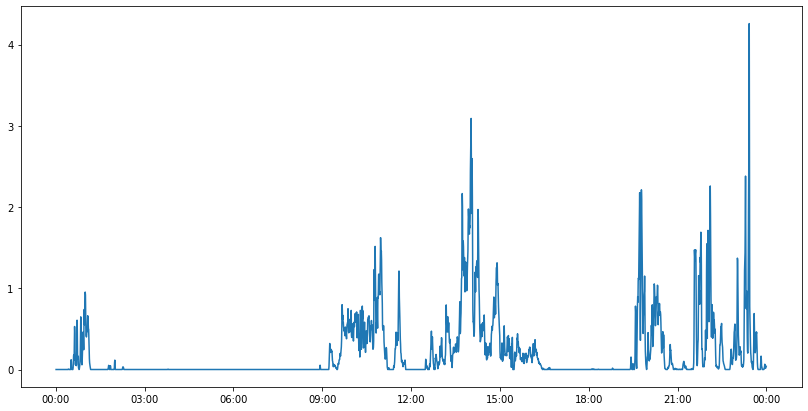

In [13]:
# plot with the rainrate

import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(1, figsize=(14,7))
ax.plot(dt_list, rainrate)
#ax.plot(time, rainrate)

# some more visual candy
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))

In [14]:
# Some adjustments to the axis labels, ticks and fonts
def load_xy_style(ax, xlabel='Time [UTC]', ylabel='Height [m]'):
    """
    Method that alters the apperance of labels on the x and y axis in place.
    
    Note:
        If xlabel == 'Time [UTC]', the x axis set to major 
        ticks every 3 hours and minor ticks every 30 minutes.
    
    Args:
        ax (matplotlib.axis) :: axis that gets adjusted
        **xlabel (string) :: name of the x axis label
        **ylabel (string) :: name of the y axis label
    
    """
    
    ax.set_xlabel(xlabel, fontweight='semibold', fontsize=15)
    ax.set_ylabel(ylabel, fontweight='semibold', fontsize=15) 
    if xlabel == 'Time [UTC]':
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=3))
        ax.xaxis.set_minor_locator(matplotlib.dates.MinuteLocator(byminute=[0,30]))
        ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(500))
    ax.tick_params(axis='both', which='major', labelsize=14, width=3, length=4)
    ax.tick_params(axis='both', which='minor', width=2, length=3)
    
def load_cbar_style(cbar, cbar_label=''):
    """
    Method that alters the apperance of labels on the color bar axis in place.
    
    Args:
        ax (matplotlib.axis) :: axis that gets adjusted
        **cbar_label (string) :: name of the cbar axis label, Defaults to empty string.
    
    """
    cbar.ax.set_ylabel(cbar_label, fontweight='semibold', fontsize=15)
    cbar.ax.tick_params(axis='both', which='major', labelsize=14, width=2, length=4)

-999.0


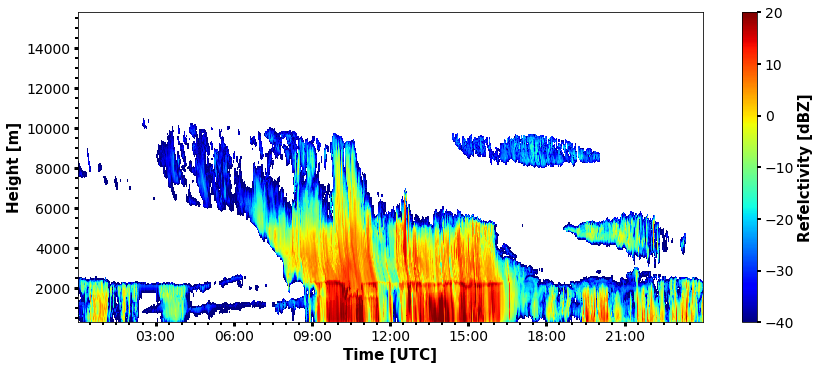

In [15]:
# reflectivity plot

Z = f.variables['Z']
print(np.min(Z))

Z = np.ma.masked_less(Z, -99)

fig, ax = plt.subplots(1, figsize=(14, 5.7))
pcmesh = ax.pcolormesh(dt_list, height, np.transpose(Z), cmap='jet', vmin=-40, vmax=20)
cbar = fig.colorbar(pcmesh)

load_xy_style(ax)
load_cbar_style(cbar, cbar_label="Refelctivity [dBZ]")


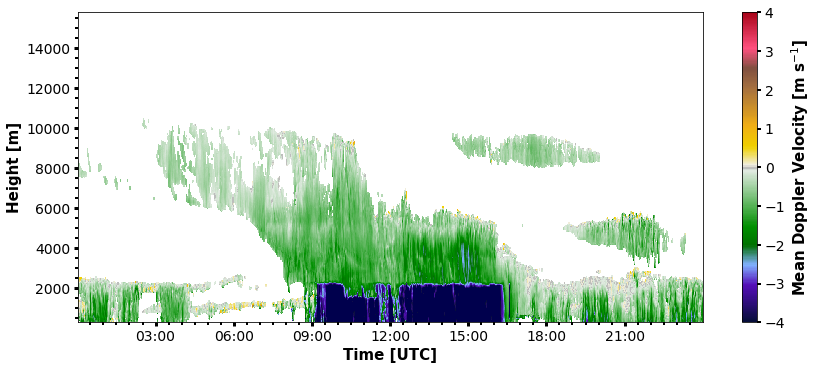

In [16]:
# similar for velocity
import Colormaps


v = f.variables['v']
v = np.ma.masked_less(v, -99)

fig, ax = plt.subplots(1, figsize=(14, 5.7))
pcmesh = ax.pcolormesh(dt_list, height, np.transpose(v),
                       cmap=Colormaps.carbonne_map, vmin=-4, vmax=4)

cbar = fig.colorbar(pcmesh)

load_xy_style(ax)
load_cbar_style(cbar, cbar_label=r"Mean Doppler Velocity [m s$^{-1}$]")

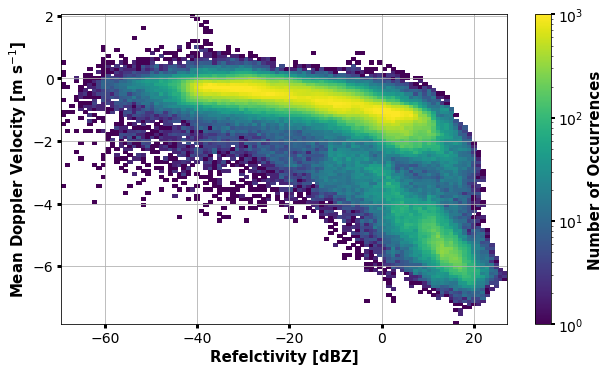

In [17]:
# 2d histogram

mask = np.ma.mask_or(Z.mask, v.mask)
Z.mask = mask
v.mask = mask
H, xedges, yedges = np.histogram2d(Z.ravel().compressed(), v.ravel().compressed(),
                                   bins=[100,100])

fig, ax = plt.subplots(1, figsize=(10, 5.7))
pcmesh = ax.pcolormesh(xedges, yedges, np.transpose(H),
                       norm=matplotlib.colors.LogNorm(1, vmax=1000),
                       cmap='viridis')
cbar = fig.colorbar(pcmesh)

load_xy_style(ax, xlabel='Refelctivity [dBZ]', ylabel=r"Mean Doppler Velocity [m s$^{-1}$]")
load_cbar_style(cbar, cbar_label='Number of Occurrences')
ax.grid()

save figure: 20180624_beta_depol.png


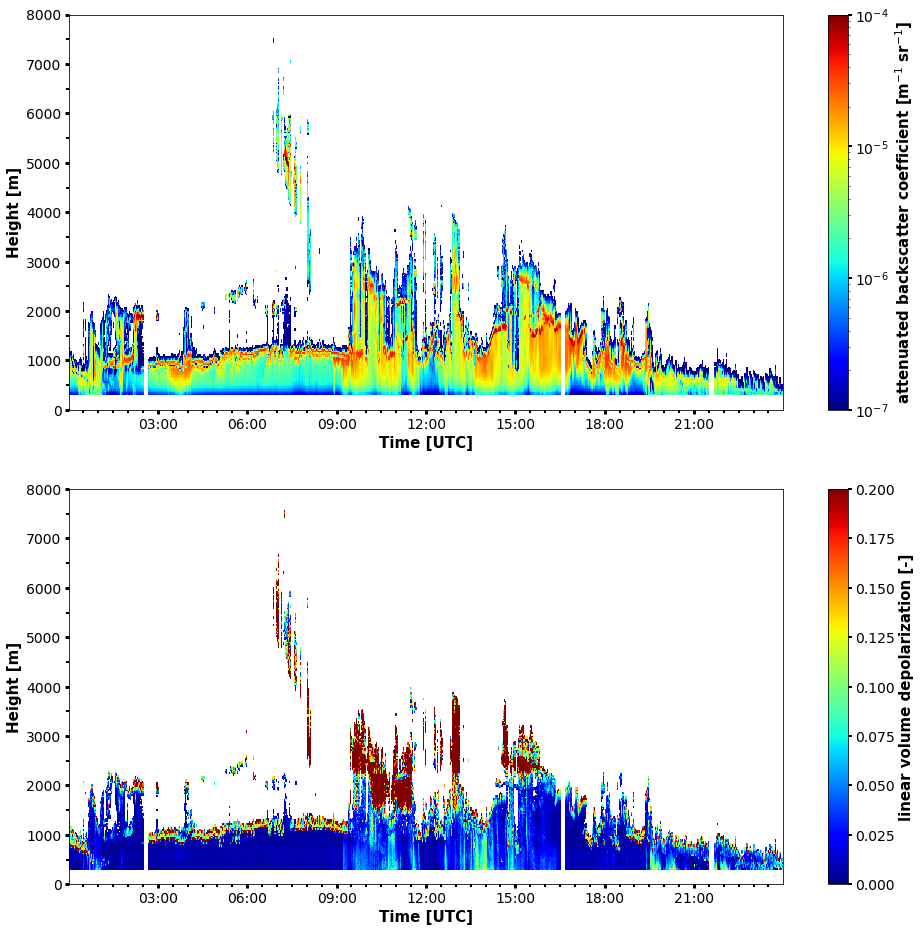

In [18]:
# lidar beta and linear depolarization in one figure with two subplots

beta, depol = f.variables['beta'], f.variables['lidar_depolarisation']

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))
ax0_pcmesh = ax0.pcolormesh(dt_list, height, np.transpose(beta), cmap='jet', 
                              norm=matplotlib.colors.LogNorm(1.e-7, vmax=1.e-4))
ax0_cbar = fig.colorbar(ax0_pcmesh, ax=ax0)
load_xy_style(ax0)
load_cbar_style(ax0_cbar, cbar_label=r"attenuated backscatter coefficient [m$^{-1}$ sr$^{-1}$]")

depol = np.ma.masked_less_equal(depol, 0.0)    # mask values below (incl) 0 for better visibility
ax1_pcmesh = ax1.pcolormesh(dt_list, height, np.transpose(depol), cmap='jet', vmin=0, vmax=0.2)
ax1_cbar = fig.colorbar(ax1_pcmesh, ax=ax1)
load_xy_style(ax1)
load_cbar_style(ax1_cbar, cbar_label=r"linear volume depolarization [-]")

ax0.set_ylim([0, 8000])
ax1.set_ylim([0, 8000])

savename = f'{dt_list[0]:%Y%m%d}_beta_depol.png'
print(f'save figure: {savename}')
fig.savefig(savename, dpi=250)